In [4]:
""" Experiment Settings """
depth_tree = 5
res = []

In [5]:
""" Libraries """
import json
import numpy as np
import pandas as pd
import psycopg2
from matplotlib import pyplot as plt

import nbimporter
from Core import Ranges, nDTree, tree_shape_relation, draw_lines, draw_box, experiment_execution

In [65]:
""" Database Connection """
conn_params = "dbname='trajectory' user='gpadmin' host='192.168.59.101' password='1234' port=5432"
conn = psycopg2.connect(conn_params)
cur = conn.cursor()

In [66]:
""" Experiment Preparation: create traj table """
sql_traj_table = """
DROP EXTERNAL TABLE IF EXISTS traj_ext;
CREATE READABLE EXTERNAL TABLE traj_ext (
    indexing_key INTEGER,
    state SMALLINT,
    geometry GEOMETRY(LINESTRINGZ),
    taxiid BIGINT,
    distributing_key INTEGER
    )
    LOCATION ('gpfdist://192.168.59.101:8081/data_{}.csv')
    FORMAT 'csv' (HEADER)
    LOG ERRORS SEGMENT REJECT LIMIT 50 ROWS;

DROP TABLE IF EXISTS traj;
CREATE TABLE traj
(
    indexing_key     INTEGER,
    state            SMALLINT,
    geometry         GEOMETRY(LINESTRINGZ),
    taxiid           BIGINT,
    distributing_key INTEGER
);

INSERT INTO traj (indexing_key, state, geometry, taxiid, distributing_key)
SELECT indexing_key, state, geometry, taxiid, distributing_key
FROM traj_ext;

DROP TABLE IF EXISTS traj_zipp;
CREATE TABLE traj_zipp
(
    indexing_key     INTEGER,
    state            SMALLINT,
    geometry         GEOMETRY(LINESTRINGZ),
    taxiid           BIGINT,
    distributing_key INTEGER
) WITH (APPENDONLY = TRUE, COMPRESSTYPE = ZSTD, COMPRESSLEVEL = 19);

INSERT INTO traj_zipp (indexing_key, state, geometry, taxiid, distributing_key)
SELECT indexing_key, state, geometry, taxiid, distributing_key
FROM traj;
""".format(depth_tree)

cur.execute(sql_traj_table)
conn.commit()

In [67]:
query_compression = """
DROP INDEX IF EXISTS traj_index_indexing_key;
CREATE INDEX traj_index_indexing_key ON traj USING btree (indexing_key);

SELECT (SELECT pg_size_pretty(pg_table_size('traj')))   AS size_table,
       (SELECT pg_size_pretty(pg_table_size('traj_zipp'))) AS size_zipp,
       (SELECT pg_size_pretty(pg_table_size('traj_index_indexing_key'))) AS size_index
"""
cur.execute(query_compression)
records = cur.fetchall()

In [68]:
result = records[0]
for val in result:
    vals = val.split(" ")
    if vals[1] == "MB":
        res.append(float(vals[0]))
    else:
        res.append(float(vals[0]) / 1000)
print(res)

[462.0, 102.0, 83.0]


In [6]:
depth_tree = [0, 1, 2, 3, 4, 5, 6, 7]
size_origin = [367.85, 367.85, 367.85, 367.85, 367.85, 367.85, 367.85, 367.85]
res_0 = [96.0, 31.0, 1.408]
res_1 = [105.0, 31.0, 1.984]
res_2 = [118.0, 32.0, 2.912]
res_3 = [134.0, 32.0, 4.512]
res_4 = [160.0, 37.0, 7.424]
res_5 = [206.0, 46.0, 13.0]
res_6 = [280.0, 64.0, 28.0]
res_7 = [462.0, 102.0, 83.0]

In [7]:
all_res = [res_0, res_1, res_2, res_3, res_4, res_5, res_6, res_7]
size_unzipp = []
size_zipped = []
size_index = []

for res in all_res:
    size_unzipp.append(res[0])
    size_zipped.append(res[1])
    size_index.append(res[2])

compression_ratio = [origin / zipped for origin, zipped in zip(size_origin, size_zipped)]

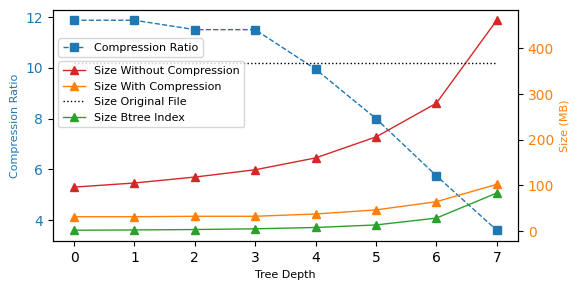

In [8]:
fig, ax1 = plt.subplots(figsize=(6, 3))

ax1.set_xlabel('Tree Depth', fontdict={"fontsize": 8})
ax1.set_ylabel('Compression Ratio', color='tab:blue', fontdict={"fontsize": 8})
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.plot(depth_tree, compression_ratio, label='Compression Ratio', color='tab:blue', marker='s', linewidth=1, linestyle='--')

ax2 = ax1.twinx()
ax2.set_ylabel('Size (MB)', color='tab:orange', fontdict={"fontsize": 8})
ax2.tick_params(axis='y', labelcolor='tab:orange')
ax2.plot(depth_tree, size_unzipp, label='Size Without Compression', color='tab:red', marker='^', linewidth=1)
ax2.plot(depth_tree, size_zipped, label='Size With Compression', color='tab:orange', marker='^', linewidth=1)
ax2.plot(depth_tree, size_origin, label='Size Original File', color='black', linewidth=1, linestyle=':')
ax2.plot(depth_tree, size_index, label='Size Btree Index', color='tab:green', marker='^', linewidth=1)

ax1.legend(fontsize=8, loc='upper left', bbox_to_anchor=(0, 0.9))
ax2.legend(fontsize=8, loc='upper left', bbox_to_anchor=(0, 0.8))
fig.savefig("figs/compression.pdf", bbox_inches='tight')
plt.show()

In [86]:
print([round(val, 2) for val in size_origin])
print([round(val, 2) for val in size_unzipp])
print([round(val, 2) for val in size_zipped])
print([round(val, 2) for val in size_index])
print([round(val, 2) for val in compression_ratio])

[0, 1, 2, 3, 4, 5, 6, 7]
[367.85, 367.85, 367.85, 367.85, 367.85, 367.85, 367.85, 367.85]
[96.0, 105.0, 118.0, 134.0, 160.0, 206.0, 280.0, 462.0]
[31.0, 31.0, 32.0, 32.0, 37.0, 46.0, 64.0, 102.0]
[1.41, 1.98, 2.91, 4.51, 7.42, 13.0, 28.0, 83.0]
[11.87, 11.87, 11.5, 11.5, 9.94, 8.0, 5.75, 3.61]
